# Exercise 3: Convolutional Neural Network (CNN)
## Detection of patterns


#### Roshana Mojtaba - 2050955
#### Attar Aidin - 2048654
#### Amjadi Bahador - 2040470
#### Joulaei Vijouyeh Roya - 2050954

We choose to skip the part of generation of new data and to use the data generated in cl


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
import pandas as pd

from keras import initializers, regularizers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from scipy import stats
import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
%run plot.py

### 1. Performance of the CNN varying the amplitude A


In [2]:
A_num= 10
All_fit= []

In [3]:
# after generatin data in different Amplitudes:
for i in range(A_num):
    A= 100 + i*100
    str0 = 'ts_L60_Z12_A{}_DX50_bias5_N10000.dat'.format(A)
    fnamex='DATA/x_'+str0
    fnamey='DATA/y_'+str0

    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x), len(x[0])

    # Show_data(x,L,"original data")

    categ = np.loadtxt(fnamey, dtype=int)
    n_class = 3    # y.argmax() - y.argmin() +1
    print('data: ',N)

    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1.

    #
    #  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
    #
    #remove average value of each sample from its values
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]

    #
    #  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
    #
    #rescale (crude version, variance should be used)
    x = x/400
        
    # Show_data(x,L,"rescaled data")

    perc_train=0.8
    N_train = int(perc_train*N)
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)
    print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

    #x_train=x_train.astype("float32")
    #y_train=y_train.astype("float32")
    #x_val=x_val.astype("float32")
    #y_val=y_val.astype("float32")

    # Keras wants an additional dimension with a 1 at the end
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)
    input_shape = (L, 1)


    # ...LESSON ...
    # reproducibility
    np.random.seed(12345)
    import tensorflow.random as tf_r
    tf_r.set_seed(12345)

    ## from keras import regularizers, initializers

    reg = tf.keras.regularizers.l2(0.2) ## raised to 0.2
    #reg = regularizers.l1(0.1)
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                            seed=None)
    NCONV = 1
    NF = 5

    # challenge: at most 600 tunable parameters
    model = Sequential()
    # 
    if NCONV==1:
        # -----2-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg,
                        activation='relu', 
                        input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7, 
                        activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))
    # 
    if NCONV==2:
        # -----1-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg, ######## TRY WITHOUT !
                        activation='relu', input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Flatten())
        model.add(Dense(9, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(6, activation='relu'))
        model.add(Dropout(0.2))
        #model.add(Dense(10, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(n_class, activation='softmax')) # softmax !

    print('----- Model',NCONV,'-----')
    # print(model.summary())

    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .RMSprop()
    # .Nadam()
    opt = tf.keras.optimizers.Adam()

    # compile the model
    # categorical_crossentropy, 3 output nodes
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt,metrics=['accuracy'])


    # ...LESSON ...
    # Hyper-parameters
    # with small minibatch it does not converge!! 
    BATCH_SIZE = 250
    EPOCHS = 100

    print('----- Model ',NCONV,'-----\nFITTING....')
    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val, y_val),
                    verbose=2, shuffle=True) 
    All_fit.append(fit)
All_fit

32/32 - 0s - loss: 0.4891 - accuracy: 0.8597 - val_loss: 0.4215 - val_accuracy: 0.8940 - 204ms/epoch - 6ms/step
Epoch 12/100
32/32 - 0s - loss: 0.4468 - accuracy: 0.8798 - val_loss: 0.3767 - val_accuracy: 0.9195 - 197ms/epoch - 6ms/step
Epoch 13/100
32/32 - 0s - loss: 0.4054 - accuracy: 0.8947 - val_loss: 0.3447 - val_accuracy: 0.9235 - 217ms/epoch - 7ms/step
Epoch 14/100
32/32 - 0s - loss: 0.3717 - accuracy: 0.9031 - val_loss: 0.3177 - val_accuracy: 0.9285 - 200ms/epoch - 6ms/step
Epoch 15/100
32/32 - 0s - loss: 0.3465 - accuracy: 0.9125 - val_loss: 0.2996 - val_accuracy: 0.9300 - 205ms/epoch - 6ms/step
Epoch 16/100
32/32 - 0s - loss: 0.3244 - accuracy: 0.9180 - val_loss: 0.2801 - val_accuracy: 0.9340 - 200ms/epoch - 6ms/step
Epoch 17/100
32/32 - 0s - loss: 0.3107 - accuracy: 0.9246 - val_loss: 0.2648 - val_accuracy: 0.9385 - 208ms/epoch - 7ms/step
Epoch 18/100
32/32 - 0s - loss: 0.2919 - accuracy: 0.9280 - val_loss: 0.2544 - val_accuracy: 0.9400 - 202ms/epoch - 6ms/step
Epoch 19/100


In [4]:
#hist = pd.DataFrame.from_dict(All_fit)
#hist.to_csv("results_DATA/all_fit_ex2.csv")
res_ex3_best = pd.read_csv("./results_DATA/all_fit_ex2.csv")

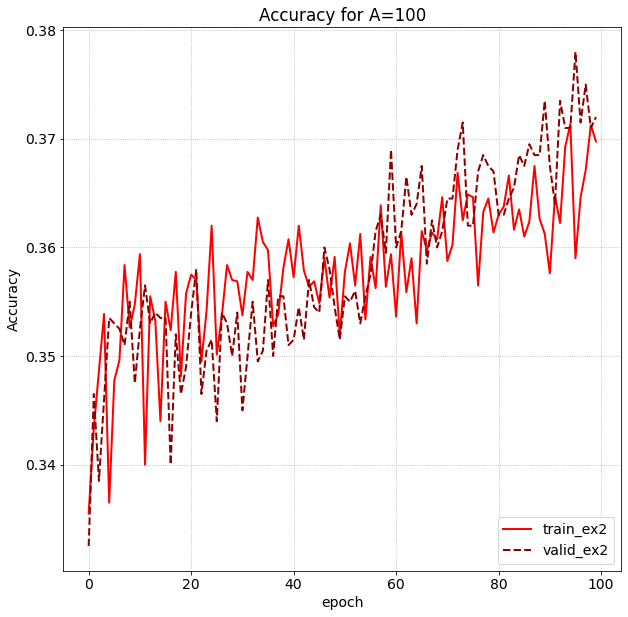

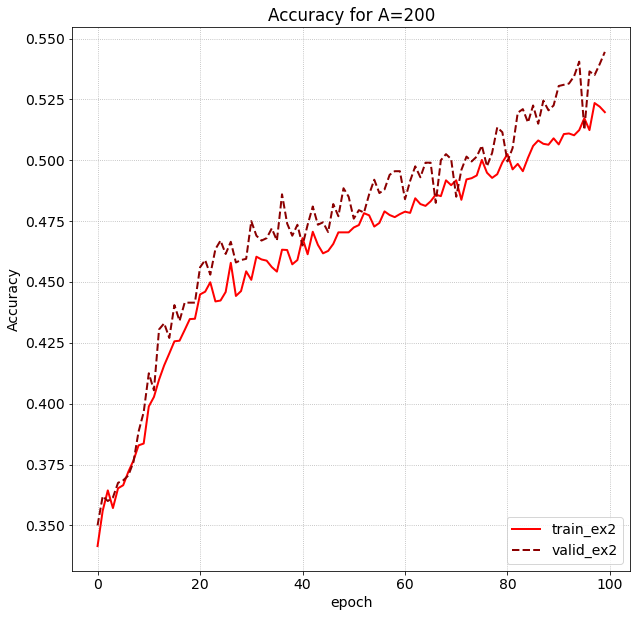

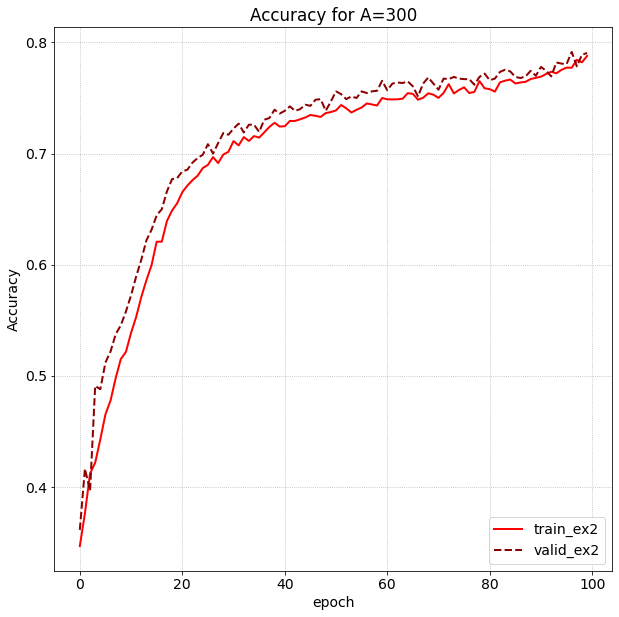

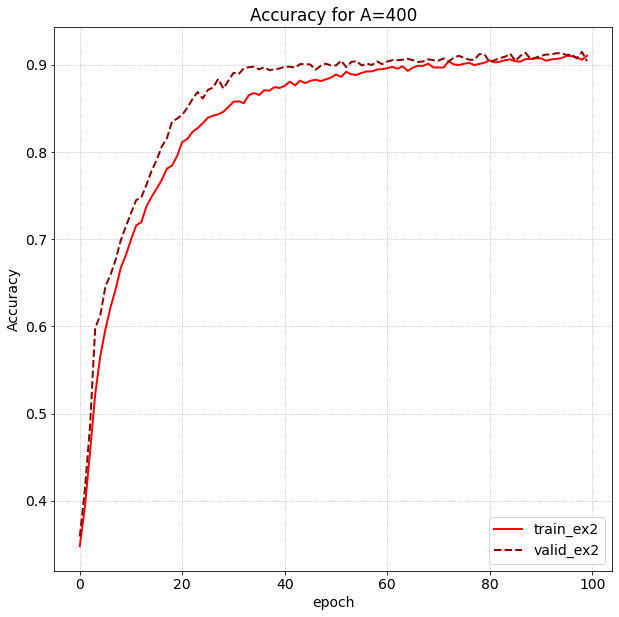

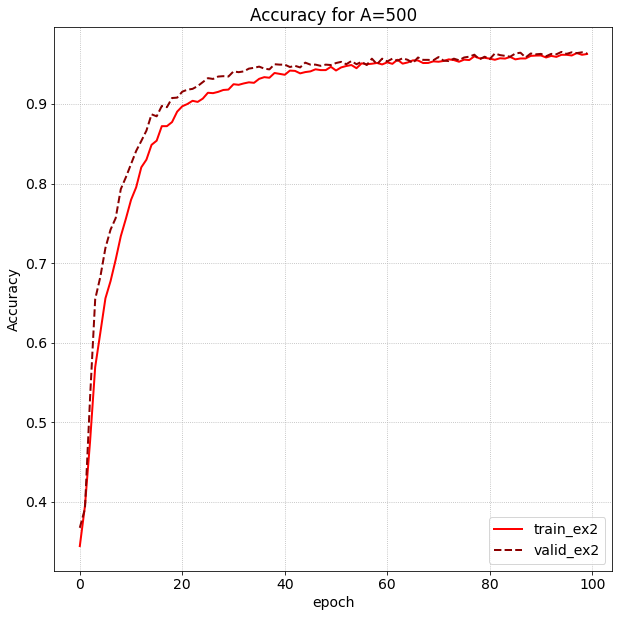

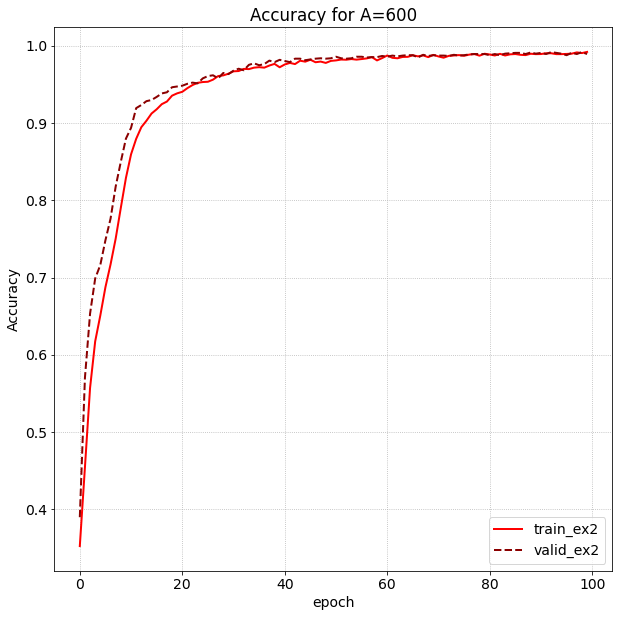

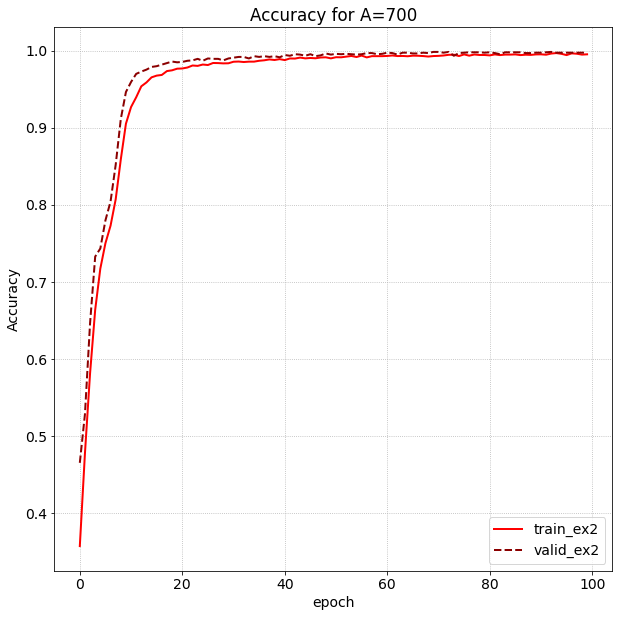

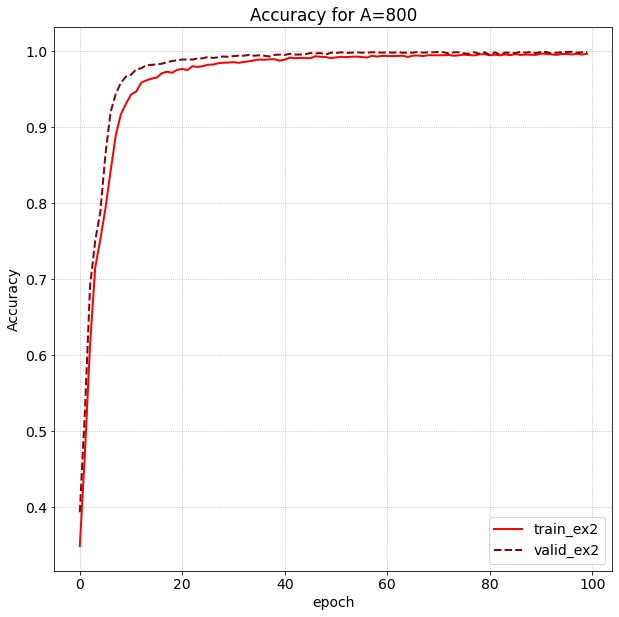

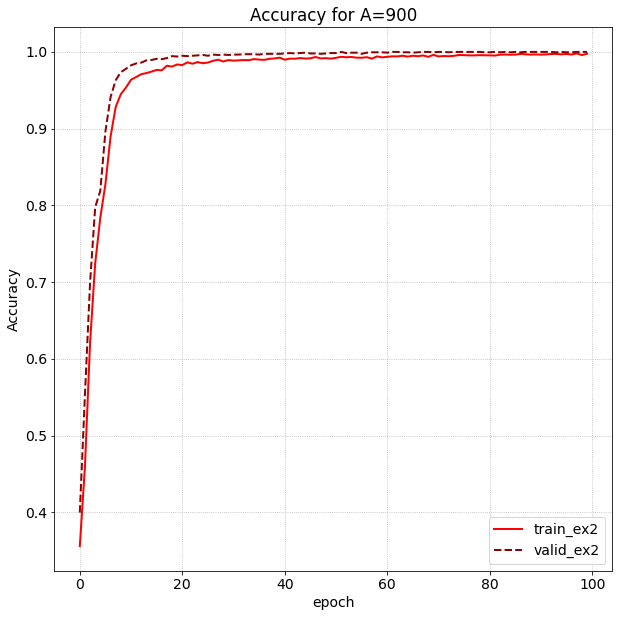

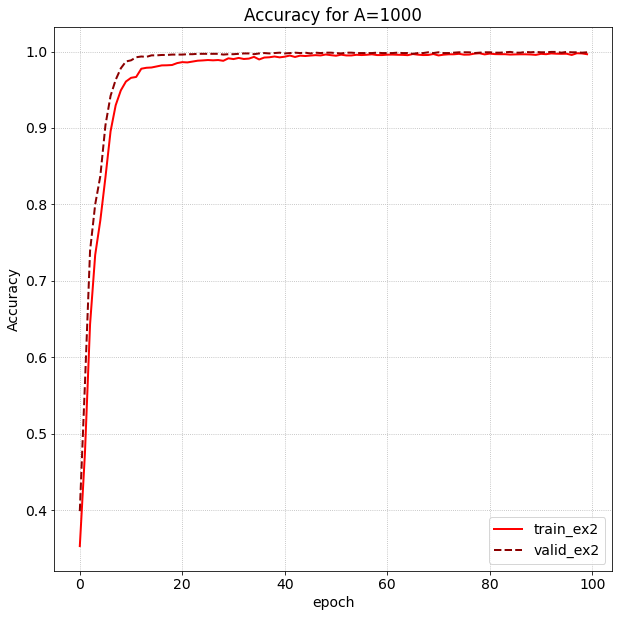

In [5]:
#ploting train and validation accuracy and loss in different Amplitude
for i in range(A_num):
    ex3_loss_train=  All_fit[i].history['loss'  ]
    ex3_loss_val  =   All_fit[i].history['val_loss']
    ex3_acc_train =   All_fit[i].history['accuracy'   ]
    ex3_acc_val   =   All_fit[i].history['val_accuracy' ]
    fig,AX=plt.subplots(1,1,figsize=(10,10))
    ax=AX
    ax.plot(ex3_acc_train, label="train_ex2",   lw = 2, ls = 'solid' , c = 'red')
    ax.plot(ex3_acc_val,   label="valid_ex2",  lw = 2, ls = 'dashed', c = 'darkred')

    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy for A={}".format(100+i*100))
    ax.legend(loc='lower right')
    ax.grid(ls='dotted')
    plt.show()

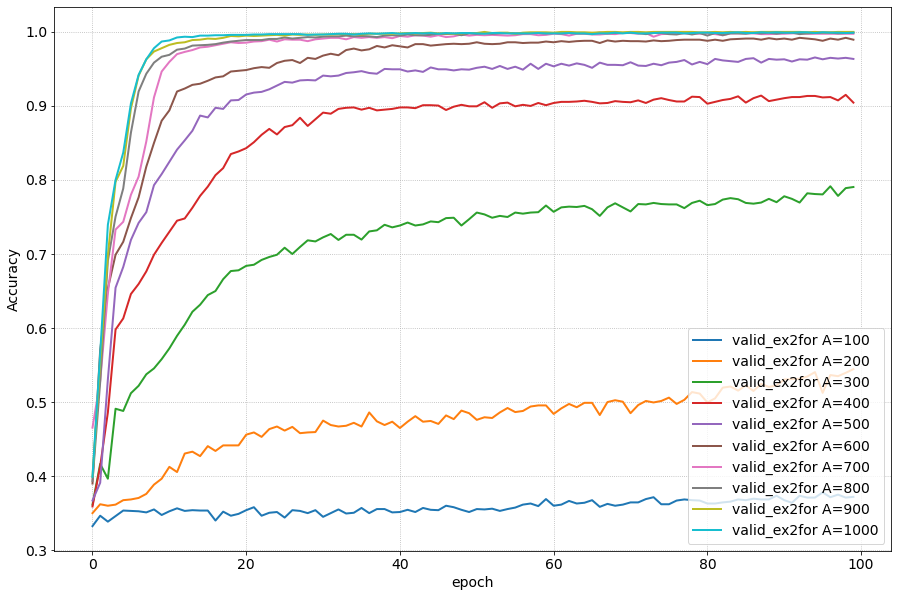

In [6]:
#ploting train and validation accuracy and loss in different Amplitude  in one figure

plt.subplots(1,1,figsize=(15,10))
for i in range(len(All_fit)):
    ex3_loss_train=  All_fit[i].history ['loss'  ]
    ex3_loss_val  =   All_fit[i].history['val_loss']
    ex3_acc_train =   All_fit[i].history['accuracy'   ]
    ex3_acc_val   =   All_fit[i].history['val_accuracy' ]

    # plt.plot(ex3_acc_train, label="train_ex2 for A={}".format(100+i*100),   lw = 2)
    plt.plot(ex3_acc_val,   label="valid_ex2for A={}".format(100+i*100),  lw = 2)

    plt.xlabel('epoch')
    plt.ylabel("Accuracy")
    #plt.title("Accuracy for A={}".format(100+i*100))
    plt.legend(loc='lower right')
    plt.grid(ls='dotted')
plt.show()

Text(0.5, 1.0, 'Loss mean for last 10 epochs')

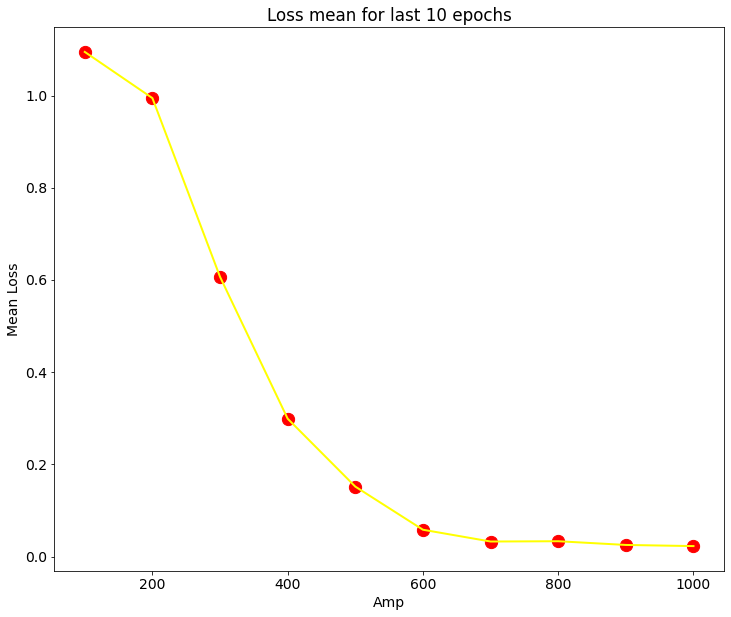

In [7]:
#Loss mean for last 10 epochs in diffferent Amplitude
means=[]
As=[]
plt.subplots(1,1,figsize=(12,10))
for i in range(len(All_fit)):
    mean=  np.mean(All_fit[i].history ['loss'][-10:])
    means.append(mean)
    As.append(100+i*100)
    #plt.scatter(100+i*100,mean, label="loss for A={}".format(100+i*100),s=150)
    plt.scatter(100+i*100,mean, color='r',s=150)

    plt.ylabel('Mean Loss')
    plt.xlabel('Amp')
    #plt.legend()
plt.plot(As,means,lw=2,c='yellow')
plt.title('Loss mean for last 10 epochs')

Text(0.5, 1.0, 'Accuracy mrsn for last 10 epochs')

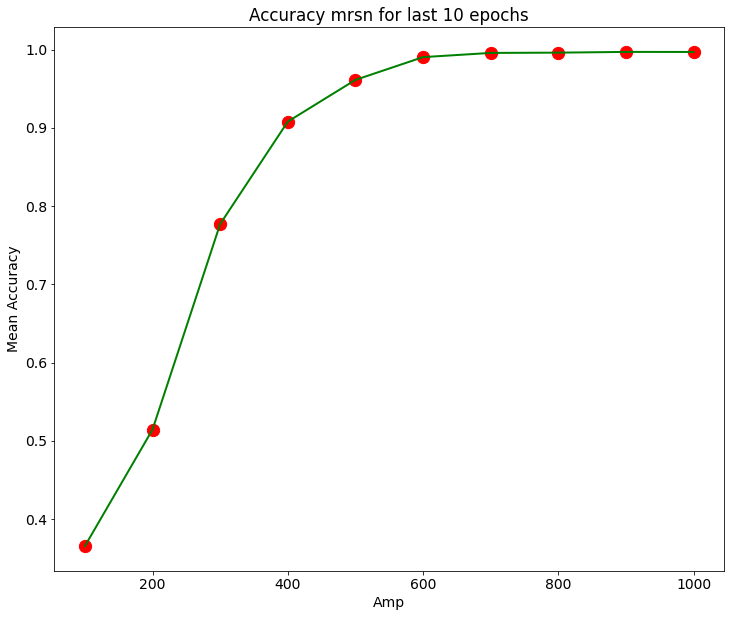

In [8]:
#Accuracy mean for last 10 epochs in diffferent Amp

means=[]
As=[]
plt.subplots(1,1,figsize=(12,10))
for i in range(len(All_fit)):
    mean=  np.mean(All_fit[i].history ['accuracy'][-10:])
    means.append(mean)
    As.append(100+i*100)
    #plt.scatter(100+i*100,mean, label="loss for A={}".format(100+i*100),s=150)
    plt.scatter(100+i*100,mean, color='r',s=150)

    plt.ylabel('Mean Accuracy')
    plt.xlabel('Amp')
    #plt.legend()
plt.plot(As,means,lw=2,c='green')
plt.title('Accuracy mrsn for last 10 epochs')

### 2. Performance of the CNN varying the regularization


#### Read data

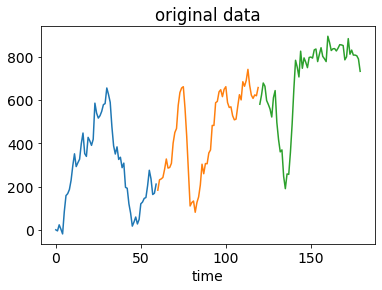

data:  10000
10000 60


In [9]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

print(N, L)

#### Rescale data and split them to training and validation set

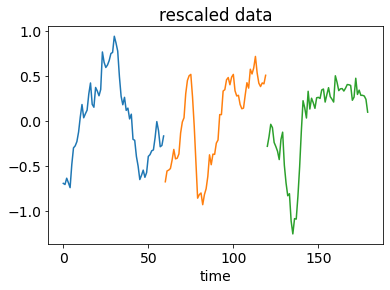

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [10]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

In [11]:
def create_CNN(n_class, reg, lam, fil, k_size, Poolsize, bias_reg, act_reg):
    ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

    model = Sequential()
    if bias_reg == True:        
        model.add(Conv1D(filters = fil, kernel_size = k_size[0],
                            kernel_regularizer = reg(lam),
                            kernel_initializer=ini,
                            bias_regularizer = reg(lam),
                            bias_initializer = ini,
                            activation = "relu",
                            input_shape = input_shape
                            ))
    elif act_reg == True:    
        model.add(Conv1D(filters = fil, kernel_size = k_size[0],
                            kernel_regularizer = reg(lam),
                            kernel_initializer=ini,
                            activity_regularizer = reg(lam),
                            activation = "relu",
                            input_shape = input_shape
                            ))
    else:     
        model.add(Conv1D(filters = fil, kernel_size = k_size[0],
                            kernel_regularizer = reg(lam),
                            kernel_initializer=ini,
                            activation = "relu",
                            input_shape = input_shape
                            ))
        
    model.add(MaxPooling1D(Poolsize))
    #model.add(AveragePooling1D(Poolsize))
    model.add(Conv1D(filters = fil, kernel_size = k_size[1], activation = "relu"))
    #model.add(MaxPooling1D(Poolsize))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax')) # softmax !
    
    return model

In [12]:
def compile_model(n_class = 3, reg = regularizers.l2, lam = 0.001, fil = 5, 
                  k_size = [11, 7], Poolsize = 5, bias_reg = False, act_reg = False):
    # create the mode
    model=create_CNN(n_class, reg, lam, fil, k_size, Poolsize, bias_reg, act_reg)
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer = "adam", metrics = ["accuracy"])
    return model

In [13]:
# ...LESSON ...
# reproducibility
import tensorflow.random as tf_r
tf_r.set_seed(12345)

NCONV = 1
NF = 5

# Gridsearch takes too long, saved the data in a csv file and read the results from there
'''
model_gridsearch = KerasClassifier(build_fn=compile_model)

# define parameter dictionary
reg = [regularizers.l1, regularizers.l2, regularizers.l1_l2]
lam = [0.1,0.01,0.001,0.0001]
param_grid = dict(reg = reg , lam = lam)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train, epochs=250, batch_size = 250, shuffle = True, verbose = 0)'''


#results = pd.DataFrame.from_dict(grid_result.cv_results_)
#results.to_csv('results_DATA/GridSearchResults_New.csv')

'\nmodel_gridsearch = KerasClassifier(build_fn=compile_model)\n\n# define parameter dictionary\nreg = [regularizers.l1, regularizers.l2, regularizers.l1_l2]\nlam = [0.1,0.01,0.001,0.0001]\nparam_grid = dict(reg = reg , lam = lam)\n\n# call scikit grid search module\ngrid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)\ngrid_result = grid.fit(x_train,y_train, epochs=250, batch_size = 250, shuffle = True, verbose = 0)'

In [14]:
results = pd.read_csv('results_DATA/GridSearchResults_New.csv')
best_result = results[results["rank_test_score"] == 1]
best_result

reg_best = regularizers.l1_l2#best_result.param_reg.values[0]
lam_best  = float(best_result.param_lam.values[0])
print(reg_best, lam_best)

<function l1_l2 at 0x7f28df6a74d0> 0.0001


In [15]:
BATCH_SIZE = 250
EPOCHS = 100

model      = compile_model(reg=reg_best ,lam=lam_best)
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True)

#hist = pd.DataFrame.from_dict(fit.history)
#hist.to_csv("results_DATA/best_fit_ex3.csv")

Epoch 1/100
32/32 - 1s - loss: 1.0985 - accuracy: 0.3550 - val_loss: 1.0946 - val_accuracy: 0.3735 - 880ms/epoch - 28ms/step
Epoch 2/100
32/32 - 0s - loss: 1.0850 - accuracy: 0.4000 - val_loss: 1.0677 - val_accuracy: 0.4210 - 232ms/epoch - 7ms/step
Epoch 3/100
32/32 - 0s - loss: 1.0319 - accuracy: 0.5020 - val_loss: 0.9866 - val_accuracy: 0.5700 - 225ms/epoch - 7ms/step
Epoch 4/100
32/32 - 0s - loss: 0.9206 - accuracy: 0.6367 - val_loss: 0.8365 - val_accuracy: 0.7195 - 224ms/epoch - 7ms/step
Epoch 5/100
32/32 - 0s - loss: 0.7781 - accuracy: 0.7245 - val_loss: 0.6696 - val_accuracy: 0.8010 - 198ms/epoch - 6ms/step
Epoch 6/100
32/32 - 0s - loss: 0.6203 - accuracy: 0.7972 - val_loss: 0.5194 - val_accuracy: 0.8500 - 196ms/epoch - 6ms/step
Epoch 7/100
32/32 - 0s - loss: 0.5044 - accuracy: 0.8361 - val_loss: 0.4135 - val_accuracy: 0.8775 - 247ms/epoch - 8ms/step
Epoch 8/100
32/32 - 0s - loss: 0.4223 - accuracy: 0.8659 - val_loss: 0.3416 - val_accuracy: 0.8965 - 210ms/epoch - 7ms/step
Epoch 9

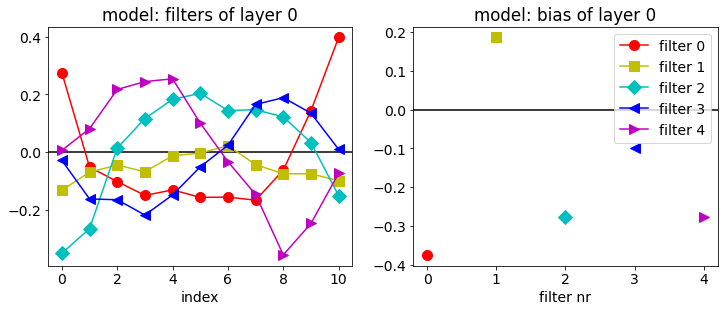

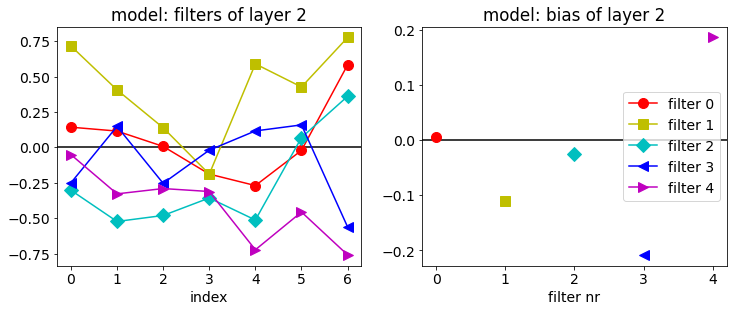

In [16]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

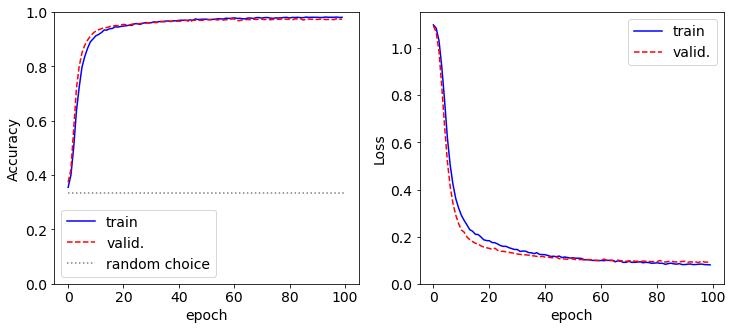

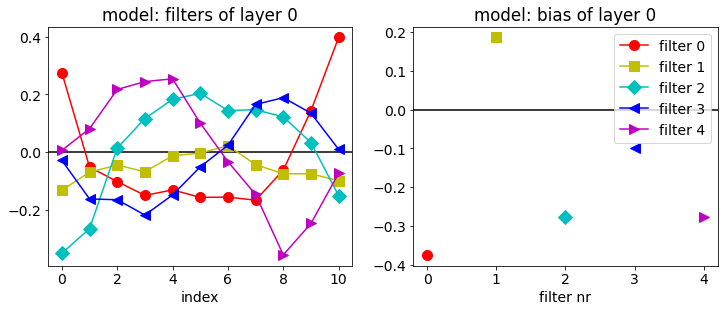

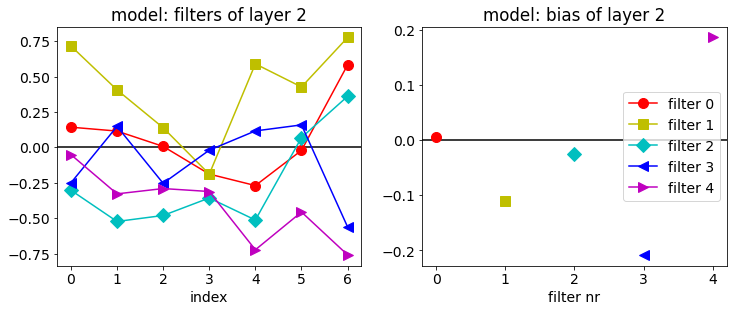

In [17]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

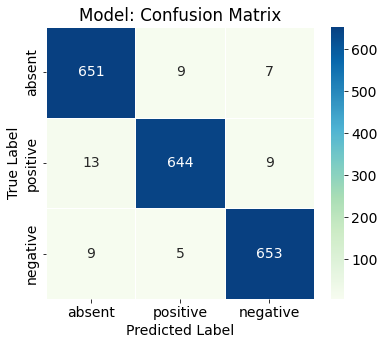

In [18]:
LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)

#print(classification_report(max_y_val, max_y_pred_val))

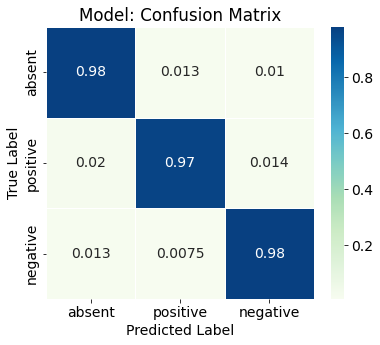

In [19]:
# Normalized Confusion matrix

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions, normalize='true')
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                #fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)

#print(classification_report(max_y_val, max_y_pred_val))

### 3. Best CNN model of 2020-21

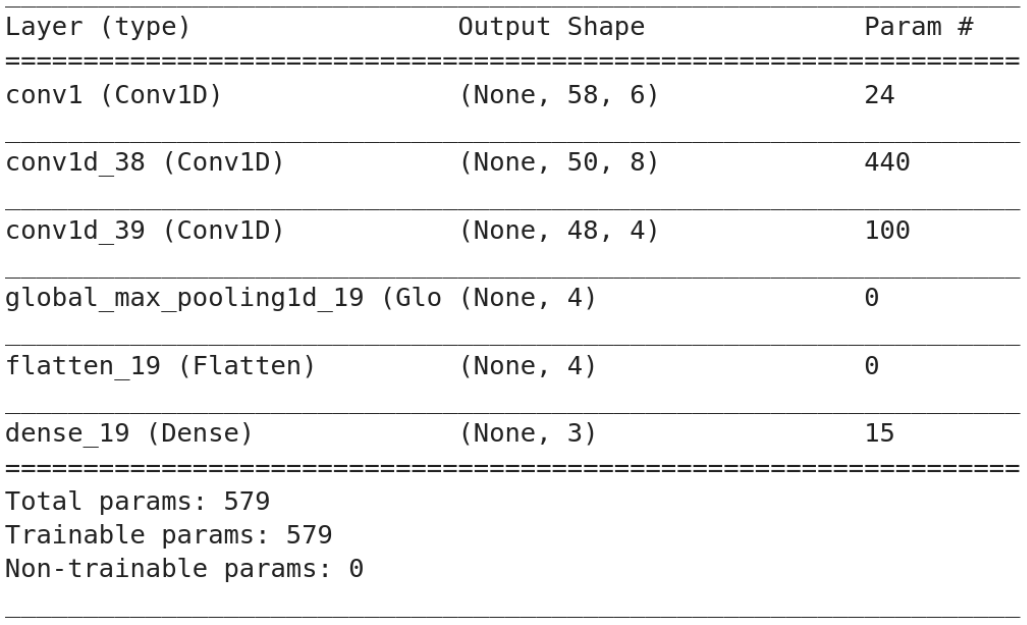

In [20]:
from IPython.display import Image
Image('figures/image-20220322-134146.png', width=100)

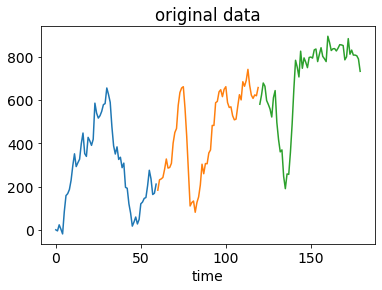

data:  10000


In [21]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

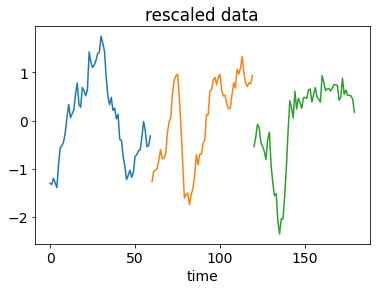

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [22]:
"""Rescaling the Data"""

def reg_scale(x):
    return x/400

def std_scale(x):
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    return x/np.sqrt(x.var())

def norm_scale(x):
    return (x - np.min(x, axis=0)) / np.abs(np.max(x, axis=0) - np.min(x, axis=0))

def log_scale(x): 
    x = x - np.min(x, axis=0) + 0.0000001 #shifting the data to be greater than 0
    return np.log10(x)

x     =  reg_scale (x)
x     =  std_scale (x)
# x   =  norm_scale(x)
# x   =  log_scale (x)

Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

# x_train=x_train.astype("float32")
# y_train=y_train.astype("float32")
# x_val=x_val.astype("float32")
# y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

In [23]:
def create_CNN(reg, lam, init, kernel_size):

    if Ex_No =="Ex4":

        model = Sequential()
        model.add(Conv1D(filters=6, kernel_size=kernel_size[0], 
                         kernel_initializer=init, 
                         kernel_regularizer=reg(lam),
                         activation='relu', 
                         input_shape=input_shape))
        model.add(Conv1D(filters=8, kernel_size=kernel_size[1], 
                         kernel_initializer=init, 
                         kernel_regularizer=reg(lam),
                         activation='relu', 
                         input_shape=input_shape))
        model.add(Conv1D(filters=4, kernel_size=kernel_size[2], 
                         kernel_initializer=init, 
                         kernel_regularizer=reg(lam),
                         activation='relu', 
                         input_shape=input_shape)) 

        model.add(GlobalMaxPooling1D())
        model.add(Flatten())
        model.add(Dense(3, activation='softmax'))

    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, 
    optimizer = "adam", metrics = ["accuracy"])
    
    return model

In [24]:
import tensorflow.random as tf_r
tf_r.set_seed(12345)

BATCH_SIZE = 250
EPOCHS = 100
Ex_No ="Ex4"

'''
model_gridsearch = KerasClassifier(build_fn= create_CNN)

# define parameter dictionary
init = ['random_normal','GlorotNormal', 'GlorotUniform']
reg  = [regularizers.l1, regularizers.l2, regularizers.l1_l2]
lam  = [0.001,0.0001,0]
k_size=[[11,8,5], [11,5,5], [5,5,5],[5,3,3]]

param_grid = dict(reg = reg , lam = lam, init=init, kernel_size=k_size)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train, epochs=EPOCHS, batch_size = BATCH_SIZE, shuffle = True, verbose = 0)
'''

"\nmodel_gridsearch = KerasClassifier(build_fn= create_CNN)\n\n# define parameter dictionary\ninit = ['random_normal','GlorotNormal', 'GlorotUniform']\nreg  = [regularizers.l1, regularizers.l2, regularizers.l1_l2]\nlam  = [0.001,0.0001,0]\nk_size=[[11,8,5], [11,5,5], [5,5,5],[5,3,3]]\n\nparam_grid = dict(reg = reg , lam = lam, init=init, kernel_size=k_size)\n# call scikit grid search module\ngrid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)\ngrid_result = grid.fit(x_train,y_train, epochs=EPOCHS, batch_size = BATCH_SIZE, shuffle = True, verbose = 0)\n"

In [25]:
"""Storing GridSearch Result"""
#results = pd.DataFrame.from_dict(grid_result.cv_results_)
#results.to_csv('results_DATA/EX4_GridSearchResults.csv')

'Storing GridSearch Result'

In [28]:
"""Reading GridSearch Result"""

results = pd.read_csv('results_DATA/EX4_GridSearchResults.csv')
best_result = results[results["rank_test_score"] == 1]

init_best        = best_result.param_init.values[0]  #is GlorotUniform
reg_best         = regularizers.L1 #best_result.param_reg.values[0]
lam_best         = best_result.param_lam.values[0]
kernel_size_best = [5,5,5] #best_result.param_kernel_size.values[0]

print("best kernel initializer:",   init_best)
print("\nbest kernel regularizer:", reg_best)
print("\nbest lambda:",             lam_best)
print("\nbest kernel size:",        kernel_size_best)

best kernel initializer: GlorotUniform

best kernel regularizer: <class 'keras.regularizers.L1'>

best lambda: 0.0

best kernel size: [5, 5, 5]


In [29]:
BATCH_SIZE = 250
EPOCHS = 100
Ex_No ="Ex4"

model_best = create_CNN(reg_best, lam_best, init_best, kernel_size_best)

fit_ex4 = model_best.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True)

#hist = pd.DataFrame.from_dict(fit_ex4.history)
#hist.to_csv("results_DATA/best_fit_ex4.csv")

Epoch 1/100
32/32 - 1s - loss: 1.0645 - accuracy: 0.3447 - val_loss: 1.0325 - val_accuracy: 0.3535 - 1s/epoch - 41ms/step
Epoch 2/100
32/32 - 0s - loss: 0.9994 - accuracy: 0.4076 - val_loss: 0.9607 - val_accuracy: 0.4965 - 428ms/epoch - 13ms/step
Epoch 3/100
32/32 - 1s - loss: 0.9180 - accuracy: 0.5648 - val_loss: 0.8606 - val_accuracy: 0.6070 - 507ms/epoch - 16ms/step
Epoch 4/100
32/32 - 0s - loss: 0.7825 - accuracy: 0.7111 - val_loss: 0.6730 - val_accuracy: 0.8510 - 478ms/epoch - 15ms/step
Epoch 5/100
32/32 - 1s - loss: 0.5478 - accuracy: 0.8898 - val_loss: 0.4354 - val_accuracy: 0.8945 - 501ms/epoch - 16ms/step
Epoch 6/100
32/32 - 0s - loss: 0.3556 - accuracy: 0.9090 - val_loss: 0.3182 - val_accuracy: 0.9030 - 486ms/epoch - 15ms/step
Epoch 7/100
32/32 - 0s - loss: 0.2842 - accuracy: 0.9110 - val_loss: 0.2790 - val_accuracy: 0.9065 - 486ms/epoch - 15ms/step
Epoch 8/100
32/32 - 0s - loss: 0.2567 - accuracy: 0.9158 - val_loss: 0.2602 - val_accuracy: 0.9110 - 488ms/epoch - 15ms/step
Epo

#### Ex3 & Ex4 Best Models Comparison

In [30]:
"""reading ex3 best model stored result"""

res_ex3_best = pd.read_csv("./results_DATA/best_fit_ex3.csv")
res_ex4_best = pd.read_csv("./results_DATA/best_fit_ex4.csv")

ex3_loss_train=  res_ex3_best['loss'  ]
ex3_loss_val  =  res_ex3_best['val_loss']
ex4_loss_train=  res_ex4_best['loss'  ]
ex4_loss_val  =  res_ex4_best['val_loss']

ex3_acc_train =  res_ex3_best['accuracy'   ]
ex3_acc_val   =  res_ex3_best['val_accuracy' ]
ex4_acc_train =  res_ex4_best['accuracy'   ]
ex4_acc_val   =  res_ex4_best['val_accuracy' ]

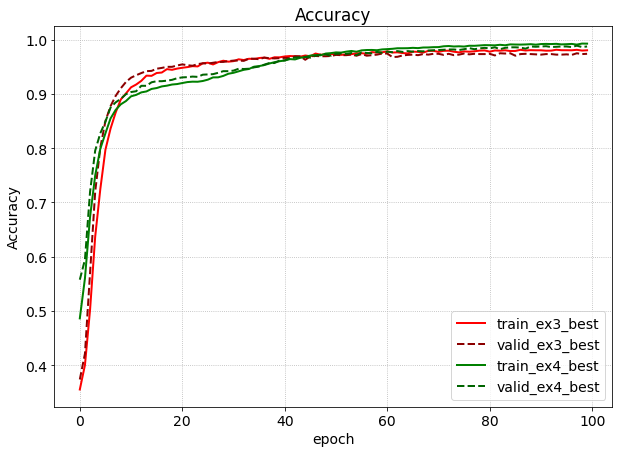

In [31]:
fig,AX=plt.subplots(1,1,figsize=(10,7))
ax=AX
ax.plot(ex3_acc_train, label="train_ex3_best",   lw = 2, ls = 'solid' , c = 'red')
ax.plot(ex3_acc_val,   label="valid_ex3_best",  lw = 2, ls = 'dashed', c = 'darkred')
ax.plot(ex4_acc_train, label="train_ex4_best",   lw = 2, ls = 'solid' , c = 'green')
ax.plot(ex4_acc_val,   label="valid_ex4_best",  lw = 2, ls = 'dashed', c = 'darkgreen')
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy")
ax.legend(loc='lower right')
ax.grid(ls='dotted')


# ax=AX[1]
# ax.plot(ex3_loss_train,label="train_ex3_best",   lw = 2, ls = 'solid' , c = 'red')
# ax.plot(ex3_loss_val,label="valid._ex3_best",  lw = 2, ls = 'dashed', c = 'darkred')
# ax.plot(ex4_loss_train,label="train_ex4_best",   lw = 2, ls = 'solid' , c = 'green')
# ax.plot(ex4_loss_val,label="valid._ex4_best",  lw = 2, ls = 'dashed', c = 'darkgreen')
# ax.set_xlabel('epoch')
# ax.set_ylabel("Loss")
# ax.set_title("Loss")
# ax.legend()
# ax.grid(ls='dotted')

# fig.suptitle('Using Different Scaling Functions', fontsize=16)
plt.show()

It seems that ex4 model, indeed if tuned with proper paramters, is able
to achive higher degrees of accuracy w.r.t the initial model which the previous
exercises are done on. Let's take a closer look:

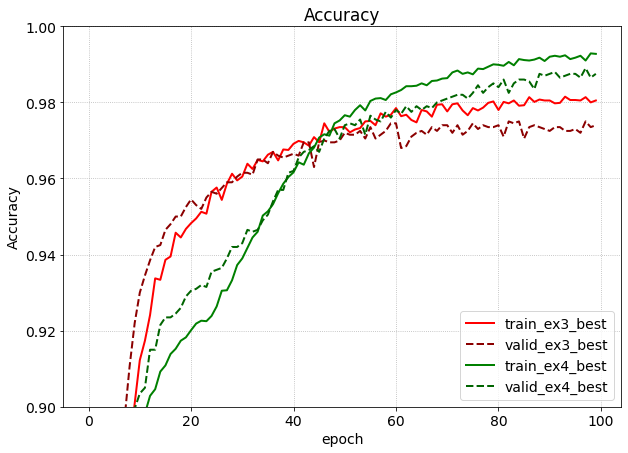

In [32]:
fig,AX=plt.subplots(1,1,figsize=(10,7))
ax=AX
ax.plot(ex3_acc_train, label="train_ex3_best",   lw = 2, ls = 'solid' , c = 'red')
ax.plot(ex3_acc_val,   label="valid_ex3_best",  lw = 2, ls = 'dashed', c = 'darkred')
ax.plot(ex4_acc_train, label="train_ex4_best",   lw = 2, ls = 'solid' , c = 'green')
ax.plot(ex4_acc_val,   label="valid_ex4_best",  lw = 2, ls = 'dashed', c = 'darkgreen')
ax.set_xlabel('epoch')
ax.set_ylim(0.9,1)
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy")
ax.legend(loc='lower right')
ax.grid(ls='dotted')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1cb9264e-65a5-431d-a980-16667908489e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>